# Brent Oil Price Change Point Modeling (Raw Prices) - Colab Version

Setup & Imports

In [2]:
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az

# Plotting setup
sns.set(style="whitegrid")

# Load Data
from google.colab import files
uploaded = files.upload()

Saving brent_oil_log_returns.csv to brent_oil_log_returns.csv


Preprocessing

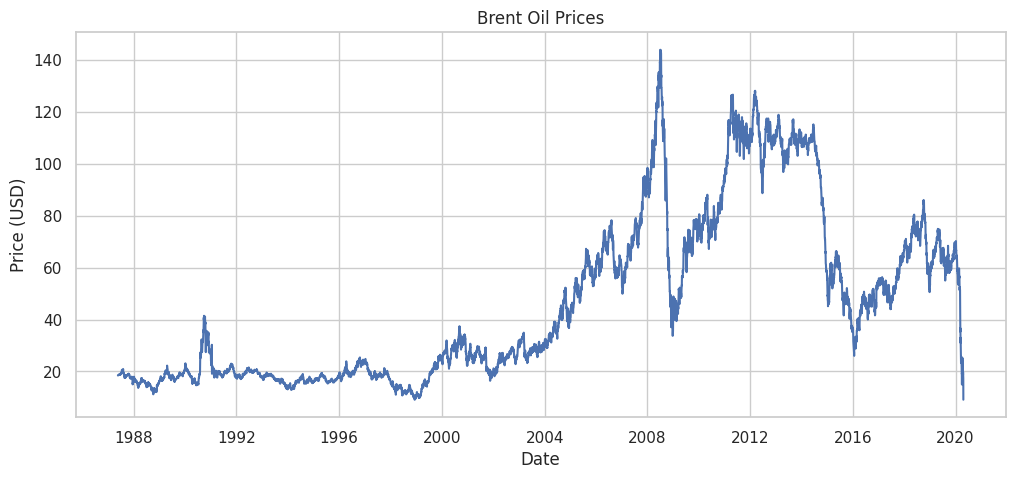

In [3]:
df = pd.read_csv("brent_oil_log_returns.csv")

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

price_data = df['Price'].values
n = len(price_data)

# Plot the raw prices
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Price'])
plt.title("Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

Model: Single Change Point in Raw Price Mean

In [4]:
with pm.Model() as change_point_model:
    # Prior for the switch point (change point index)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n - 1)

    # Priors for the mean price before and after the change point
    mu_1 = pm.Normal('mu_1', mu=np.mean(price_data), sigma=np.std(price_data) * 2)
    mu_2 = pm.Normal('mu_2', mu=np.mean(price_data), sigma=np.std(price_data) * 2)

    # Common std dev
    sigma = pm.HalfNormal('sigma', sigma=np.std(price_data))

    # Create deterministic mean vector
    mu = pm.math.switch(tau >= np.arange(n), mu_1, mu_2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=price_data)

    # Sampling
    trace = pm.sample(5000, tune=2000, cores=2, return_inferencedata=True, target_accept=0.95)


Output()

Trace Plot

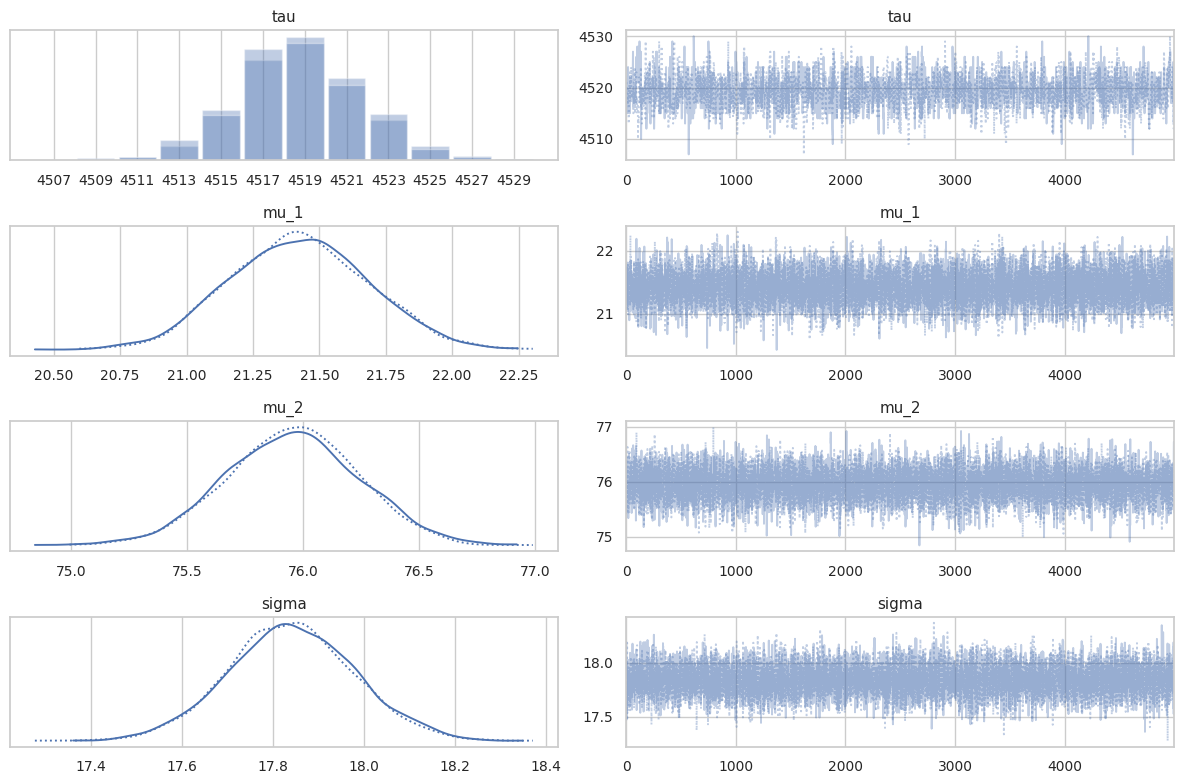

           mean     sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tau    4519.294  3.012  4513.000  4524.000      0.064    0.054    2182.0   
mu_1     21.423  0.262    20.954    21.919      0.003    0.003    9606.0   
mu_2     75.954  0.287    75.430    76.498      0.003    0.003    8839.0   
sigma    17.840  0.138    17.574    18.100      0.001    0.001   10375.0   

       ess_tail  r_hat  
tau      2099.0    1.0  
mu_1     6316.0    1.0  
mu_2     6772.0    1.0  
sigma    7350.0    1.0  


In [5]:
az.plot_trace(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma'])
plt.tight_layout()
plt.show()

summary = az.summary(trace, var_names=['tau', 'mu_1', 'mu_2', 'sigma'])
print(summary)

Change Point Interpretation


 Detected change point at index 4519, approx date: 2005-02-23


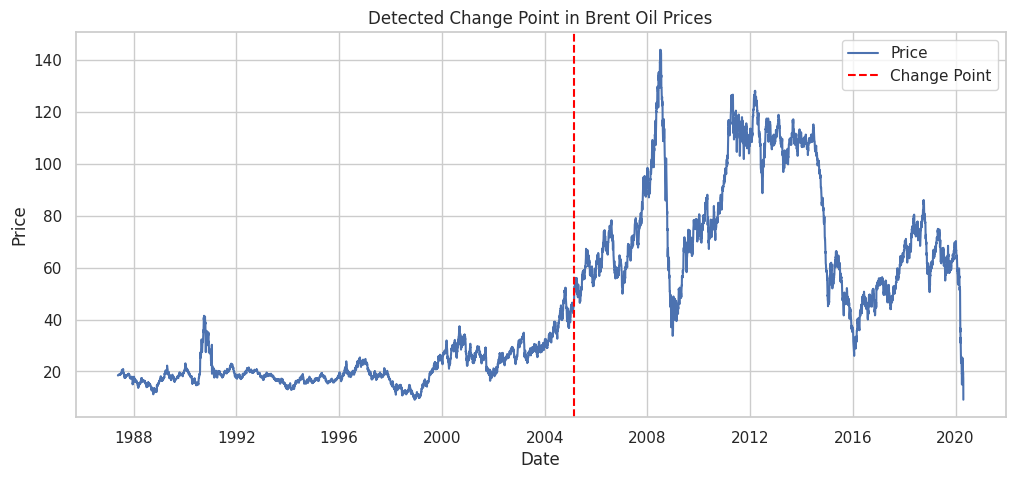

In [6]:
tau_mean = int(summary.loc['tau', 'mean'])
change_date = df.loc[tau_mean, 'Date']
print(f"\n Detected change point at index {tau_mean}, approx date: {change_date.strftime('%Y-%m-%d')}")

# Visualizing change point
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Price'], label='Price')
plt.axvline(change_date, color='red', linestyle='--', label='Change Point')
plt.title("Detected Change Point in Brent Oil Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Quantify the Change

In [7]:
mu1 = summary.loc['mu_1', 'mean']
mu2 = summary.loc['mu_2', 'mean']
diff = mu2 - mu1
perc_change = (diff / mu1) * 100

print(f"\n Mean price before change: {mu1:.2f}")
print(f" Mean price after change: {mu2:.2f}")
print(f" Change: {diff:.2f} USD ({perc_change:.2f}%)")


 Mean price before change: 21.42
 Mean price after change: 75.95
 Change: 54.53 USD (254.54%)


Build and save single change point table

In [9]:
single_entry = [{
    "change_number": 1,
    "change_index": tau_mean,
    "change_date": change_date.strftime("%Y-%m-%d"),
    "mean_before": float(mu1),
    "mean_after": float(mu2),
    "delta": float(diff),
    "pct_change": float(perc_change)
}]

cp_df_single = pd.DataFrame(single_entry)

# Save to CSV
out_csv_single = "single_change_point.csv"
cp_df_single.to_csv(out_csv_single, index=False)

print(f"\nSaved single change point to {out_csv_single}")
print(cp_df_single)


Saved single change point to single_change_point.csv
   change_number  change_index change_date  mean_before  mean_after   delta  \
0              1          4519  2005-02-23       21.423      75.954  54.531   

   pct_change  
0  254.544181  
